In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection

%matplotlib inline
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('data/adult.csv')
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [3]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
df.describe(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


<AxesSubplot:xlabel='income', ylabel='count'>

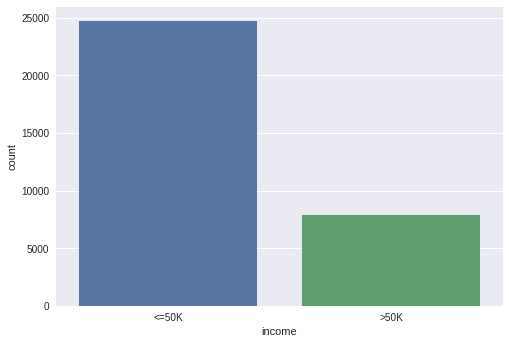

In [5]:
sns.countplot(data=df, x='income')

In [6]:
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

In [7]:
types = df.dtypes
cat_features = list(types[(types=='object')].index)
cat_features

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native.country']

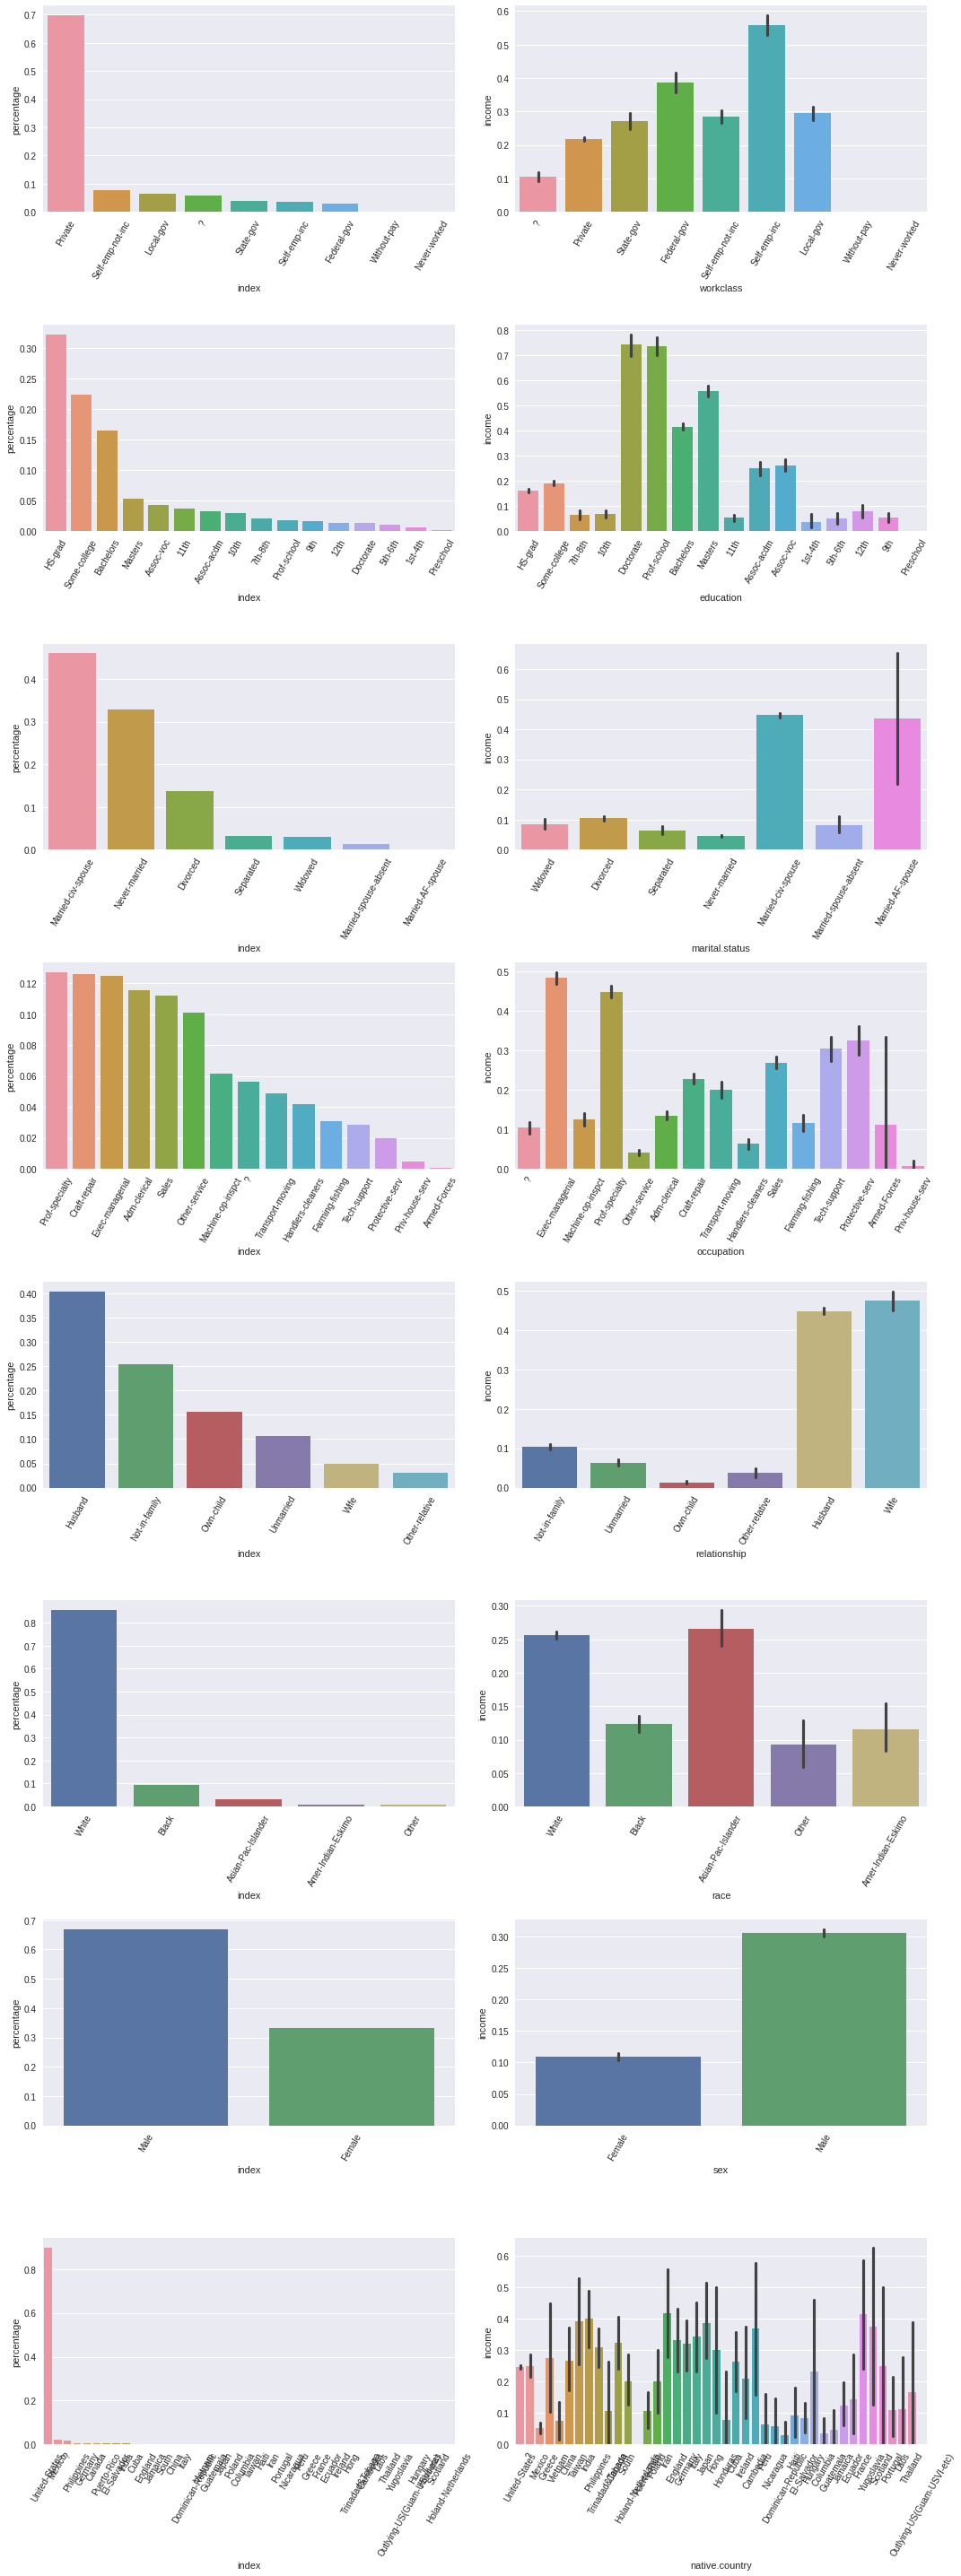

In [8]:
n = len(cat_features)
fig, axes = plt.subplots(n, 2, figsize=(15, 40))

for i, feature in enumerate(cat_features):
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index()
                  )
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    
    mean_barplot = sns.barplot(data=df, x=feature, y='income', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
    
plt.tight_layout()

In [9]:

adult_data = df.copy()
#Определяем школьников в отдельную категорию
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
        or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' else x
)
#Объединяем категории Assoc-acdm и Assoc-voc (доценты)
adult_data['education'] = adult_data['education'].apply(
    lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x
)
#Объединяем вдовцов,разведенных и живущих раздельно в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x
)
#Объединяем всех женатых/за мужем в одну категорию
adult_data['marital.status'] = adult_data['marital.status'].apply(
    lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x
)
#Объединяем мужей и жен в одну категорию, остальных в другую
adult_data['relationship'] = adult_data['relationship'].apply(
    lambda x: 'In relationship' if (x == 'Husband' or x == 'Whife') else 'Not in relationship'
)

#Объединяем типы занятоностей, не приносящих дохода в одну категорию
adult_data['workclass'] = adult_data['workclass'].apply(
    lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x
)
#Объединяем всех приезжих в одну категорию
adult_data['native.country'] = adult_data['native.country'].apply(
    lambda x: 'Other' if x != 'United-States' else x
)

In [10]:
#Логарифмируем числовые признаки, чтобы придать им форму нормального распределения
adult_data['capital.gain'] = np.log(adult_data['capital.gain']+1)
adult_data['capital.loss'] = np.log(adult_data['capital.loss']+1)
adult_data['fnlwgt'] = np.log(adult_data['fnlwgt']+1)

#Создаем новый признак - разность между приростом капитала и его убылью
adult_data['capital_diff'] = abs((adult_data['capital.gain'] - adult_data['capital.loss']))

In [11]:
#Удаляем лишние признаки
adult_data = adult_data.drop(['education.num', 'capital.gain', 'capital.loss'], axis=1)

<AxesSubplot:>

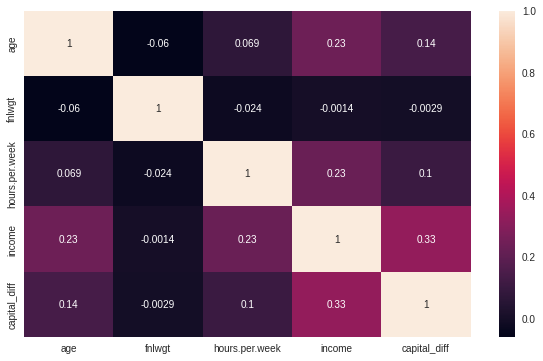

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(adult_data.corr(), annot=True)

In [13]:
dummy_data = pd.get_dummies(adult_data, drop_first=True)
dummy_data

,age,fnlwgt,hours.per.week,income,capital_diff,workclass_Federal-gov,workclass_Local-gov,workclass_No income,workclass_Private,workclass_Self-emp-inc,...,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Not in relationship,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,native.country_United-States
0,90,11.252262,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,82,11.797134,18,0,8.379539,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,66,12.133835,40,0,8.379539,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
3,54,11.851966,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
4,41,12.486216,40,0,8.268988,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,12.644821,40,0,0.000000,0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,1
32557,27,12.458010,38,0,0.000000,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,1
32558,40,11.947140,40,1,0.000000,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
32559,58,11.931050,40,0,0.000000,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,1


In [14]:
X = dummy_data.drop('income', axis=1)
y = dummy_data['income']

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

In [16]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
log_reg = linear_model.LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
print('accuracy на тестовой выборке: ', log_reg.score(X_test_scaled, y_test))
y_pred_test = log_reg.predict(X_test_scaled)
print('f1 score на тестовой выборке: ', metrics.f1_score(y_test, y_pred_test))

accuracy на тестовой выборке:  0.8378627360663289
f1 score на тестовой выборке:  0.6320557491289198


In [18]:
param_grid = {
    'penalty' : ['l2', 'none'],
    'solver'  : ['lbfgs', 'saga'] 
}
grid_search = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42,
        max_iter=3000
    ),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
%time grid_search.fit(X_train_scaled, y_train)
print('accuracy на тестовой выборке: ', grid_search.score(X_test_scaled, y_test))
y_pred_test = grid_search.predict(X_test_scaled)
print('f1 score на тествой выборке: ', metrics.f1_score(y_test, y_pred_test))
print('Наилучшие значения гиперпараметров: ', grid_search.best_params_)

CPU times: user 5.61 s, sys: 3.73 s, total: 9.35 s
Wall time: 45.5 s
accuracy на тестовой выборке:  0.8378627360663289
f1 score на тествой выборке:  0.6320557491289198
Наилучшие значения гиперпараметров:  {'penalty': 'l2', 'solver': 'lbfgs'}


In [19]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]

grid_search_1 = model_selection.GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=3000),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)
%time grid_search_1.fit(X_train_scaled, y_train)
print('accuracy на тестовой выборке: ', grid_search_1.score(X_test_scaled, y_test))
y_pred_test = grid_search_1.predict(X_test_scaled)
print('f1 score на тествой выборке: ', metrics.f1_score(y_test, y_pred_test))
print('Наилучшие значения гиперпараметров: ', grid_search_1.best_params_)

/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/p

CPU times: user 6 s, sys: 3.23 s, total: 9.22 s
Wall time: 4min 11s
accuracy на тестовой выборке:  0.8380162751420236
f1 score на тествой выборке:  0.6322760543743465
Наилучшие значения гиперпараметров:  {'C': 0.9, 'penalty': 'l2', 'solver': 'lbfgs'}


In [20]:
print('Наилучшая модель: ', grid_search_1.best_estimator_)
print('Наилучшее значение точности при кросс валидации: ', grid_search_1.best_score_)

Наилучшая модель:  LogisticRegression(C=0.9, max_iter=3000, random_state=1)
Наилучшее значение точности при кросс валидации:  0.8440187715857206


In [21]:
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.423713,0.068165,0.002954,0.000856,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.835893,0.840691,0.840307,0.841428,0.82895,0.837454,0.004673,51
1,0.860837,0.275621,0.003569,0.001615,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.835893,0.840691,0.840307,0.841428,0.82895,0.837454,0.004673,51


<AxesSubplot:xlabel='param_solver', ylabel='param_C'>

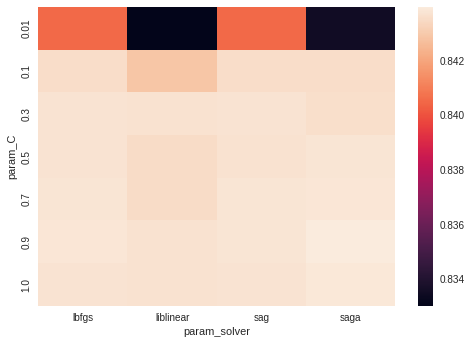

In [22]:
visual = pd.pivot_table(
    pd.DataFrame(grid_search_1.cv_results_),
    values='mean_test_score',
    index='param_C',
    columns='param_solver'                    
)
sns.heatmap(visual)

In [23]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}

random_search = model_selection.RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=2000),
    param_distributions = param_grid,
    cv=5,
    n_iter=10,
    n_jobs=-1
)

%time random_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test_scaled, y_test)))
y_test_pred = random_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))


/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/home/vadim/anaconda3/envs/sf/lib/p

CPU times: user 670 ms, sys: 49.5 ms, total: 720 ms
Wall time: 1min 14s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.63
Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.89}


In [24]:
dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)
print('Train: ', metrics.f1_score(y_train, y_train_pred))
y_test_pred = dt.predict(X_test_scaled)
print('Test: ', metrics.f1_score(y_test, y_test_pred))

Train:  1.0
Test:  0.610062893081761


In [25]:
param_grid = {
    'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
    'max_depth'      : list(np.linspace(1, 30, 50, dtype=int)),
    'criterion'      : ['gini', 'entropy']
}

random_search_tree = model_selection.RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_distributions=param_grid,
    cv=5,
    n_iter=50,
    n_jobs=-1
)
%time random_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test_scaled, y_test)))
y_test_pred = random_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: user 701 ms, sys: 60.1 ms, total: 761 ms
Wall time: 7.19 s
accuracy на тестовом наборе: 0.84
f1_score на тестовом наборе: 0.63
Наилучшие значения гиперпараметров: {'min_samples_leaf': 36, 'max_depth': 15, 'criterion': 'entropy'}


In [26]:
param_grid = {
    'n_estimators'      : list(range(80, 200, 30)),
    'min_samples_leaf'  : [5],
    'max_depth'         : list(np.linspace(20, 40, 10, dtype=int))
}

random_search_forest = model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    cv=5,
    n_iter=10,
    n_jobs=-1
)
%time random_search_forest.fit(X_train_scaled, y_train) 
y_train_pred = random_search_forest.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test_scaled, y_test)))
y_test_pred = random_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 1.97 s, sys: 26.1 ms, total: 2 s
Wall time: 35 s
f1_score на обучающем наборе: 0.73
accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.67
Наилучшие значения гиперпараметров: {'n_estimators': 80, 'min_samples_leaf': 5, 'max_depth': 37}


In [27]:
param_grid = {
    'n_estimators'      : list(range(100, 200, 30)),
    'min_samples_leaf'  : [5, 7],
    'max_depth'         : [10, 15, 20, 25]
}

random_search_forest = model_selection.RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    cv=5,
    n_iter=10,
    n_jobs=-1
)

random_search_forest.fit(X_train_scaled, y_train)

y_pred_test = random_search_forest.predict(X_test_scaled)
print('f1 score: ', metrics.f1_score(y_test, y_pred_test))

f1 score:  0.6644951140065146


In [28]:
param_grid = {
    'n_estimators'      : list(range(100, 200, 30)),
    'min_samples_leaf'  : [5, 7],
    'max_depth'         : [10, 15, 20, 25]
}

random_search_forest = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

random_search_forest.fit(X_train_scaled, y_train)

y_pred_test = random_search_forest.predict(X_test_scaled)
print('f1 score: ', metrics.f1_score(y_test, y_pred_test))

f1 score:  0.6669072536990257


In [29]:
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

print('Версия hyperopt: ', hyperopt.__version__)

Версия hyperopt:  0.2.7


In [38]:
space = {
    'n_estimators'      : hp.quniform('n_estimators', 100, 200, 1),
    'max_depth'         : hp.quniform('max_depth', 15, 26, 1),
    'min_samples_leaf'  : hp.quniform('min_samples_leaf', 2, 10, 1)
}

random_state = 42

def hyperopt_rf(params, cv=5, X=X_train_scaled, y=y_train, random_state=random_state):
    params = {
        'n_estimators'      : int(params['n_estimators']),
        'max_depth'         : int(params['max_depth']),
        'min_samples_leaf'  : int(params['min_samples_leaf']),
    }
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    #score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

In [42]:
%%time

trials = Trials()

best = fmin(
    hyperopt_rf, # наша функция 
    space=space, # пространство гиперпараметров
    algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20, # максимальное количество итераций
    trials=trials, # логирование результатов
    rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
)

print('Наилучшие значения гиперпараметров:', best)

100%|██████████| 20/20 [01:03<00:00,  3.20s/trial, best loss: -0.7573202792131267]
Наилучшие значения гиперпараметров: {'max_depth': 18.0, 'min_samples_leaf': 2.0, 'n_estimators': 103.0}
CPU times: user 1min 3s, sys: 35.7 ms, total: 1min 3s
Wall time: 1min 3s


In [43]:
model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('f1 на обучающих данных: ', metrics.f1_score(y_train, y_train_pred))
print('accuracy на тестовом наборе: ', model.score(X_test_scaled, y_test))
print('f1 на тестовом наборе: ', metrics.f1_score(y_test, y_test_pred))

f1 на обучающих данных:  0.7573202792131267
accuracy на тестовом наборе:  0.8602794411177644
f1 на тестовом наборе:  0.6705286024619841


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

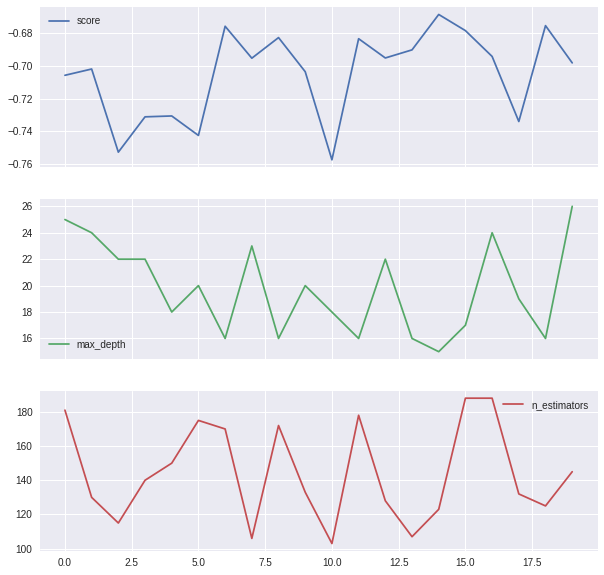

In [41]:
tpe_result = np.array([
    [
        x['result']['loss'],
        x['misc']['vals']['max_depth'][0],
        x['misc']['vals']['n_estimators'][0]
    ] for x in trials.trials
])

tpe_result_df = pd.DataFrame(tpe_result, columns=['score', 'max_depth', 'n_estimators'])

tpe_result_df.plot(subplots=True, figsize=(10, 10))